<a href="https://colab.research.google.com/github/melanAm/Improving-Neural-Networks/blob/main/Improving_neural_networks_by_preventing_co_adaptation_of_feature_detectors_Experiments_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implementation of the paper "Improving neural networks by preventing
co-adaptation of feature detectors", Experiments on MNIST code

In [ ]:
#import required packages
import numpy as np
import math
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import _use_grad_for_differentiable
import matplotlib.pyplot as plt
import os
import copy
import json
import time

In [ ]:
#hyper parameters
num_epochs = 3000
batch_size = 100
lr_init = 0.1
lr_decay_factor = 0.998
max_weight = np.sqrt(15.0)       #maximum square length of every neuron's weight vector
moment_init = 0.5
moment_final = 0.99
num_steps = 500
momentum_schedule = np.concatenate([np.linspace(moment_init,moment_final,num_steps),np.full(shape=(num_epochs-num_steps,),fill_value=moment_final)])
mean = 0
std = 0.01
num_class = 10
random_seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [ ]:
os.mkdir('dataset')

In [ ]:
#load mnist dataset
path = '/content/dataset'
train_transform = transforms.Compose([transforms.RandomCrop(size=(28,28),padding=(2,)),transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
val_transform =  transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = datasets.MNIST(root=path,train=True,download=True,transform=train_transform)
val_dataset = datasets.MNIST(root=path,train=False,download=True,transform=val_transform)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=torch.cuda.is_available())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.2MB/s]


Extracting /content/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /content/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]


Extracting /content/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting /content/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]

Extracting /content/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/dataset/MNIST/raw



# Neural Network Model

In [ ]:
#multi-layer perceptron input layer:784, hidden_layers:1200-1200, output_layer:10
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet,self).__init__()
    self.fc1 = nn.Linear(in_features=784,out_features=1200,bias=True)
    self.fc2 = nn.Linear(in_features=1200,out_features=1200,bias=True)
    self.layer_out = nn.Linear(in_features=1200,out_features=10,bias=True)
    self.layers = [self.fc1,self.fc2,self.layer_out]
    self.initialize()

  def initialize(self):
    for layer in self.layers:
      torch.nn.init.normal_(layer.weight,mean=0.0,std=0.01)
      torch.nn.init.zeros_(layer.bias)

  def forward(self,x):
    x = x.view(-1,784)
    x = F.dropout(x,p=0.2,training=self.training)
    x = F.relu(self.fc1(x))
    x = F.dropout(x,p=0.5,training=self.training)
    x = F.relu(self.fc2(x))
    x = F.dropout(x,p=0.5,training=self.training)
    x = self.layer_out(x)
    return x

#customized SGD optimizer

In [ ]:
class CSGD(optim.Optimizer):
  def __init__(self,params,lr_init,lr_decay_factor,momentum_schedule,max_weight,differentiable=False):
    self.epoch = 0
    self.lr_decay_factor = lr_decay_factor
    self.momentum_schedule = momentum_schedule
    self.max_weight = max_weight
    defaults = dict(lr=lr_init,momentum=self.momentum_schedule[0],differentiable=differentiable)
    super().__init__(params,defaults)

  def schedule(self):
      self.epoch += 1
      for group in self.param_groups:
        group["lr"] = group["lr"] * self.lr_decay_factor
        group["momentum"] = self.momentum_schedule[self.epoch]

  def _delw(self,grads,momentum_buffer_list,lr,momentum):
        lrm = -lr*(1-momentum)
        del_w = torch._foreach_mul(grads,lrm)
        if momentum_buffer_list:
          buf_x_moment = torch._foreach_mul(momentum_buffer_list,momentum)
          torch._foreach_add_(del_w,buf_x_moment)
        return del_w

  @_use_grad_for_differentiable
  def step(self):
      for group in self.param_groups:
        lr = group["lr"]
        momentum = group["momentum"]
        params = []
        grads = []
        momentum_buffer_list = []
        for p in group["params"]:
          if p.grad is not None:
            params.append(p)
            grads.append(p.grad)
            state = self.state[p]
            momentum_buffer = state.get("momentum_buffer")
            if momentum_buffer != None:
              momentum_buffer_list.append(momentum_buffer)
        del_w = self._delw(grads,momentum_buffer_list,lr,momentum)
        torch._foreach_add_(params,del_w)
        for p,momentum_buffer in zip(params,del_w):
          state = self.state[p]
          state["momentum_buffer"] = momentum_buffer
          #regularize weight vector of every neuron to have square length of max_weight
          if p.dim()>1:
            norm = torch.linalg.vector_norm(p,dim=1,keepdim=True)
            nrm_coef = norm.reciprocal().mul(self.max_weight).clamp(max=1.)
            p.mul_(nrm_coef)

 **Done up to here** :) :> <3

In [ ]:
use_gpu = True
def reproducibilitySeed():
    torch_init_seed = 42
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 42
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [ ]:
model = NeuralNet().to(device)

In [ ]:
#cost function
criterion = nn.CrossEntropyLoss()

In [ ]:
#create optimizer module
optimizer = CSGD(teacher.parameters())

In [ ]:
if os.path.exists('/content/teacher')==False:
  os.mkdir('/content/teacher')

In [ ]:
def log(t):
        logname = os.path.join('/content/teacher', 'MLP_MNIST_DropoutPaper_CSGD_lr-init-10.txt')
        with open(logname, 'a') as f:
            f.write( json.dumps(t) + '\n')
        print(t)

In [ ]:
def train(model,criterion,optimizer,num_epochs):
  bestparams = copy.deepcopy(model.state_dict())
  best_correct = 0
  time_start = time.time()
  for epoch in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    train_correct = 0
    val_correct = 0
    model.train()
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      y_hat = model.forward(x)
      loss = criterion(y_hat,y)
      loss.backward()
      optimizer.step()

    optimizer.schedule()

    model.eval()
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      y_hat = model.forward(x)
      loss = criterion(y_hat,y)
      train_loss+= loss.item()*x.size(0)
      train_correct += (((torch.argmax(y_hat,dim=1)==y)).sum()).item()
    train_loss = train_loss/len(train_dataset)
    train_error = len(train_dataset)-train_correct
    train_acc = train_correct/len(train_dataset)

    for x,y in val_loader:
      x = x.to(device)
      y = y.to(device)
      y_hat = model.forward(x)
      loss = criterion(y_hat,y)
      val_loss += loss.item()*x.size(0)
      val_correct += (((torch.argmax(y_hat,dim=1)==y)).sum()).item()
    val_loss = val_loss/len(val_dataset)
    val_error = len(val_dataset)-val_correct
    val_acc = val_correct/len(val_dataset)

    if val_correct > best_correct:
      bestparams = copy.deepcopy(model.state_dict())
      best_correct = val_correct

    log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_correct": train_correct,
            "train_error": train_error,
            "train_acc" : train_acc,
            "val_loss": val_loss,
            "val_correct": val_correct,
            "val_error": val_error,
            "val_acc" : val_acc,
           })

  time_fin = time.time()-time_start
  print('time: {}'.format(time_fin))
  return bestparams

In [ ]:
optimized_params = train(model,criterion,optimizer,num_epochs=num_epochs)

epoch: 1
lrm: 4.9802
momentum: 0.5009819639278558
{'epoch': 1, 'train_loss': 2.3822418944040935, 'train_correct': 6164, 'train_error': 53836, 'train_acc': 0.10273333333333333, 'val_loss': 2.383527817726135, 'val_correct': 1019, 'val_error': 8981, 'val_acc': 0.1019}
epoch: 2
lrm: 4.960459200000001
momentum: 0.5019639278557114
{'epoch': 2, 'train_loss': 2.3159763062000276, 'train_correct': 5860, 'train_error': 54140, 'train_acc': 0.09766666666666667, 'val_loss': 2.3161227178573607, 'val_correct': 974, 'val_error': 9026, 'val_acc': 0.0974}
epoch: 3
lrm: 4.9407774424
momentum: 0.5029458917835672
{'epoch': 3, 'train_loss': 2.3645738160610197, 'train_correct': 5987, 'train_error': 54013, 'train_acc': 0.09978333333333333, 'val_loss': 2.3629838323593138, 'val_correct': 1035, 'val_error': 8965, 'val_acc': 0.1035}
epoch: 4
lrm: 4.9211545699936
momentum: 0.5039278557114228
{'epoch': 4, 'train_loss': 2.3327728780110677, 'train_correct': 5847, 'train_error': 54153, 'train_acc': 0.09745, 'val_loss':

KeyboardInterrupt: 

In [ ]:
optimized_params = copy.deepcopy(teacher.state_dict())

In [ ]:
#SGD, lr=0.01, momentum=0.9 , Input Dropout=20%
optimized_params = train(teacher,criterion,optimizer,num_epochs=num_epochs)

{'epoch': 1, 'train_loss': 0.6983546553055445, 'train_correct': 47338, 'train_error': 12662, 'train_acc': 0.7889666666666667, 'val_loss': 0.6630761915445328, 'val_correct': 7982, 'val_error': 2018, 'val_acc': 0.7982}
{'epoch': 2, 'train_loss': 0.29941678803414107, 'train_correct': 54841, 'train_error': 5159, 'train_acc': 0.9140166666666667, 'val_loss': 0.2748346263170242, 'val_correct': 9221, 'val_error': 779, 'val_acc': 0.9221}
{'epoch': 3, 'train_loss': 0.20368177607655524, 'train_correct': 56452, 'train_error': 3548, 'train_acc': 0.9408666666666666, 'val_loss': 0.18964646756649017, 'val_correct': 9436, 'val_error': 564, 'val_acc': 0.9436}
{'epoch': 4, 'train_loss': 0.17250994903345904, 'train_correct': 56972, 'train_error': 3028, 'train_acc': 0.9495333333333333, 'val_loss': 0.16292740676552056, 'val_correct': 9486, 'val_error': 514, 'val_acc': 0.9486}
{'epoch': 5, 'train_loss': 0.14088090778018036, 'train_correct': 57507, 'train_error': 2493, 'train_acc': 0.95845, 'val_loss': 0.1327

In [ ]:
#SGD, lr=0.01, no momentum, Input Dropout=20%
optimized_params = train(teacher,criterion,optimizer,num_epochs=num_epochs)

{'epoch': 1, 'train_loss': 2.274973742167155, 'train_correct': 19448, 'train_error': 40552, 'train_acc': 0.32413333333333333, 'val_loss': 2.2743730330467224, 'val_correct': 3302, 'val_error': 6698, 'val_acc': 0.3302}
{'epoch': 2, 'train_loss': 2.1015995657444, 'train_correct': 23088, 'train_error': 36912, 'train_acc': 0.3848, 'val_loss': 2.097918231487274, 'val_correct': 3962, 'val_error': 6038, 'val_acc': 0.3962}
{'epoch': 3, 'train_loss': 1.4993104300896327, 'train_correct': 32702, 'train_error': 27298, 'train_acc': 0.5450333333333334, 'val_loss': 1.488956618309021, 'val_correct': 5523, 'val_error': 4477, 'val_acc': 0.5523}
{'epoch': 4, 'train_loss': 1.175541691184044, 'train_correct': 37538, 'train_error': 22462, 'train_acc': 0.6256333333333334, 'val_loss': 1.1508322495222092, 'val_correct': 6356, 'val_error': 3644, 'val_acc': 0.6356}
{'epoch': 5, 'train_loss': 1.0248547171552975, 'train_correct': 40534, 'train_error': 19466, 'train_acc': 0.6755666666666666, 'val_loss': 0.9974469554

In [ ]:
#SGD, lr=0.01, momentum=0.9
optimized_params = train(teacher,criterion,optimizer,scheduler,num_epochs=num_epochs)

Adjusting learning rate of group 0 to 1.0000e-01.
{'epoch': 1, 'train_loss': 0.6229396446049213, 'train_correct': 48687, 'train_error': 11313, 'train_acc': 0.81145, 'val_loss': 0.5880341100692749, 'val_correct': 8237, 'val_error': 1763, 'val_acc': 0.8237}
Adjusting learning rate of group 0 to 1.0000e-01.
{'epoch': 2, 'train_loss': 0.2805052057777842, 'train_correct': 55096, 'train_error': 4904, 'train_acc': 0.9182666666666667, 'val_loss': 0.2568030695617199, 'val_correct': 9245, 'val_error': 755, 'val_acc': 0.9245}
Adjusting learning rate of group 0 to 1.0000e-01.
{'epoch': 3, 'train_loss': 0.19316471860433618, 'train_correct': 56633, 'train_error': 3367, 'train_acc': 0.9438833333333333, 'val_loss': 0.17781622566282748, 'val_correct': 9475, 'val_error': 525, 'val_acc': 0.9475}
Adjusting learning rate of group 0 to 1.0000e-01.
{'epoch': 4, 'train_loss': 0.15762120412041744, 'train_correct': 57242, 'train_error': 2758, 'train_acc': 0.9540333333333333, 'val_loss': 0.14398545905947685, 'va

In [ ]:
#SGD, lr=0.01, momentum=0.9, no input layer dropout
optimized_params = train(teacher,criterion,optimizer,num_epochs)

{'epoch': 1, 'train_loss': 0.25034247803191345, 'train_correct': 55604, 'train_error': 4396, 'train_acc': 0.9267333333333333, 'val_loss': 0.2363699112460017, 'val_correct': 9296, 'val_error': 704, 'val_acc': 0.9296}
{'epoch': 2, 'train_loss': 0.1676873028712968, 'train_correct': 56988, 'train_error': 3012, 'train_acc': 0.9498, 'val_loss': 0.15517611974384635, 'val_correct': 9517, 'val_error': 483, 'val_acc': 0.9517}
{'epoch': 3, 'train_loss': 0.1302365362023314, 'train_correct': 57693, 'train_error': 2307, 'train_acc': 0.96155, 'val_loss': 0.121859556871932, 'val_correct': 9637, 'val_error': 363, 'val_acc': 0.9637}
{'epoch': 4, 'train_loss': 0.10723459799929212, 'train_correct': 58036, 'train_error': 1964, 'train_acc': 0.9672666666666667, 'val_loss': 0.1045217336062342, 'val_correct': 9659, 'val_error': 341, 'val_acc': 0.9659}
{'epoch': 5, 'train_loss': 0.09329416985002657, 'train_correct': 58314, 'train_error': 1686, 'train_acc': 0.9719, 'val_loss': 0.09016837166738696, 'val_correct':

In [ ]:
#SGD, lr=0.01, momentum=0.9, no weight regularization
optimized_params = train(teacher,criterion,optimizer,num_epochs)

{'epoch': 1, 'train_loss': 0.25034247803191345, 'train_correct': 55604, 'train_error': 4396, 'train_acc': 0.9267333333333333, 'val_loss': 0.2363699112460017, 'val_correct': 9296, 'val_error': 704, 'val_acc': 0.9296}
{'epoch': 2, 'train_loss': 0.1676873028712968, 'train_correct': 56988, 'train_error': 3012, 'train_acc': 0.9498, 'val_loss': 0.15517611974384635, 'val_correct': 9517, 'val_error': 483, 'val_acc': 0.9517}
{'epoch': 3, 'train_loss': 0.1302365362023314, 'train_correct': 57693, 'train_error': 2307, 'train_acc': 0.96155, 'val_loss': 0.121859556871932, 'val_correct': 9637, 'val_error': 363, 'val_acc': 0.9637}
{'epoch': 4, 'train_loss': 0.10723459799929212, 'train_correct': 58036, 'train_error': 1964, 'train_acc': 0.9672666666666667, 'val_loss': 0.1045217336062342, 'val_correct': 9659, 'val_error': 341, 'val_acc': 0.9659}
{'epoch': 5, 'train_loss': 0.09329416985002657, 'train_correct': 58314, 'train_error': 1686, 'train_acc': 0.9719, 'val_loss': 0.09016837166738696, 'val_correct':

In [ ]:
optimized_params = train(teacher,criterion,optimizer,scheduler,num_epochs=100)

In [ ]:
optimized_params = train(teacher,criterion,optimizer,num_epochs=num_epochs)

In [ ]:
optimized_params = train(teacher,criterion,optimizer,num_epochs=num_epochs)

In [ ]:
optimized_params = train(teacher,criterion,optimizer,scheduler,num_epochs=num_epochs)

In [ ]:
optimized_params = train(teacher,criterion,optimizer,num_epochs=100)

In [ ]:
torch.save(optimized_params, '/content/teacher/MLP_MNIST_DropoutPaper_CSGD_lr0.1.pth.tar')
torch.save(dict(params={k: v.data for k, v in optimized_params.items()}),os.path.join('/content/teacher', 'MLP_MNIST_DropoutPaper_CSGD_lr0.1.pt7'))
torch.save({k: v.data for k, v in optimized_params.items()},'/content/teacher/MLP_MNIST_DropoutPaper_CSGD_lr0.1')

In [ ]:
torch.save(optimized_params, '/content/drive/MyDrive/models/MLP-mnist/mlp_mnist_teacher_RevisedPreprocessing_SGD_lr_0.0_schedulerStepLR_gamma_0.1_step_50_moment_0.9_NoWeightReg.pth.tar')
torch.save(dict(params={k: v.data for k, v in optimized_params.items()}),os.path.join('/content/drive/MyDrive/models/MLP-mnist', 'mlp_mnist_teacher_SGD_moment0.5_lr_0.0_scheduler.pt7'))
torch.save({k: v.data for k, v in optimized_params.items()},'/content/drive/MyDrive/models/MLP-mnist/mlp_mnist_teacher_SGD_moment0.5_0.lr_0.0_scheduler')

In [ ]:
torch.save(optimized_params, '/content/teacher/MLP_MNIST_Teacher_RevisedPreprocessing_Xavier_SGD_lr_0.1_0.01_momentum_0.5_InDrpout_0.2_WeightReg.pth.tar')
torch.save({k: v.data for k, v in optimized_params.items()},os.path.join('/content/teacher', 'MLP_MNIST_Teacher_RevisedPreprocessing_Xavier_SGD_lr_0.1_0.01_momentum_0.5_InDrpout_0.2_WeightReg.pt7'))
torch.save({k: v.data for k, v in optimized_params.items()},'/content/teacher/MLP_MNIST_Teacher_RevisedPreprocessing_Xavier_SGD_lr_0.1_0.01_momentum_0.5_InDrpout_0.2_WeightReg')

In [ ]:
epochs = torch.empty(100)
test_errors = torch.empty(100)
train_errors = torch.empty(100)
f = open('/content/teacher/mlp_mnist_teacher_final_0.01_ROnPlateau.txt','r')
for i,row in enumerate(f):
  row = row.split('json_stats:')
  res = json.loads(row[1])
  epochs[i]=res['epoch']
  test_errors[i]=res['test_error']
  train_errors[i]=res['train_error']

<ipython-input-44-1e6c0ce7f992>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


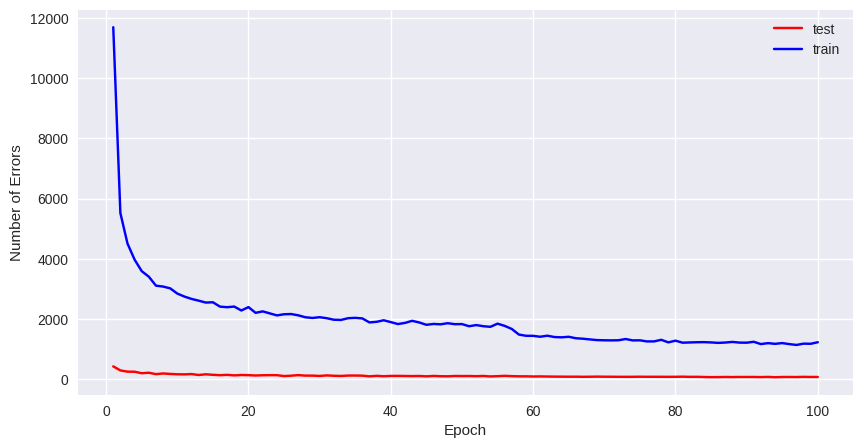

In [ ]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(epochs,test_errors,color='red',label='test')
plt.plot(epochs,train_errors,color='blue',label='train')
plt.xlabel('Epoch')
plt.ylabel('Number of Errors')
plt.legend()
plt.show()
plt.style.use('default')

In [ ]:
teacher.load_state_dict(parameters)

<All keys matched successfully>

In [ ]:
def test(model,loss_fn):
  model.eval()
  test_loss = 0.0
  test_correct = 0
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat,y)
    test_loss += loss.item()
    test_correct += (((torch.max(y_hat,dim=1)[1]==y).sum())).item()
  test_error = len(test_dataset) - test_correct
  print(f'The number of correct predictions is:{test_correct}')
  print(f'The number of false predictions is:{test_error}')



In [ ]:
test(teacher,criterion)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The number of correct predictions is:9931
The number of false predictions is:69
